# Assignment 6: Convolutional Networks

Before we start, we should assure that we have activated CUDA -- otherwise training might take very long.
In Google Colaboratory:

1. Check the options Runtime -> Change Runtime Type on top of the page.
2. In the popup window, select hardware accelerator GPU.

Afterward, the following command should run successfully:

In [1]:
import torch
# flag used for moving data to GPU if available
cuda_available = True
if torch.cuda.is_available():
  print("Successfully enabled CUDA processing")
else:
  cuda_available = False
  print("CUDA processing not available. Things will be slow :-(")

Successfully enabled CUDA processing


## Dataset

In PyTorch, a dataset stores a list of input and target tensors $(X^n, T^n)$.
In case of **FashionMNIST** dataset, the inputs are $X^n \in \mathbb R^{28\times28\times1}$ and $T^n \in \{0,\ldots,9\}$.
More precisely, the data in the dataset is provided in form of `PIL.Image.Image`, which represents an image class with some more functionality, and pixel values in range $[0, 255]$.
In order to convert these images into `torch.Tensor`'s in range $[0,1]$, we can use the [ToTensor](https://pytorch.org/vision/main/generated/torchvision.transforms.ToTensor.html) transform.
Furthermore, in `PyTorch` batches are created from datasets using the [DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) class.


### Task 1: Dataset Loading


Here, we use the [FashionMNIST dataset](https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html#torchvision.datasets.FashionMNIST) of gray images for categorical classification.

Write a function that returns the training and the testing set of FashionMNIST, using the given transform.

In [2]:
import torch
import torchvision

def datasets(transform):
  trainset = torchvision.datasets.FashionMNIST(root="/temp/FashionMNIST", train=True, download=True, transform=transform)
  testset = torchvision.datasets.FashionMNIST(root="/temp/FashionMNIST", train=True, download=True, transform=transform)

  return trainset, testset

### Test 1: Data Types

When we create the dataset with `transform=None`, all inputs shall be of type `PIL.Image.Image`, and all targets are integral.

In [3]:
import PIL
trainset, testset = datasets(transform=None)

for x,t in trainset:
  # check datatype of input x
  assert isinstance(x, PIL.Image.Image)
  # check datatype of target t
  assert isinstance(t, int)

100%|██████████| 26421880/26421880 [00:01<00:00, 14819901.02it/s]


Extracting /temp/FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to /temp/FashionMNIST/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 255045.77it/s]


Extracting /temp/FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /temp/FashionMNIST/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5118233.86it/s]


Extracting /temp/FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /temp/FashionMNIST/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 21484852.73it/s]


Extracting /temp/FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /temp/FashionMNIST/FashionMNIST/raw



### Task 2: Data Visulization
Create the dataset with `transform=None`. Plot 40 images of trainset using `matplotlib`.

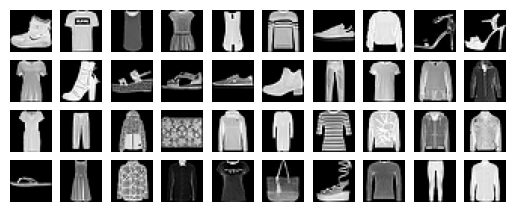

In [4]:
# plot images
trainset, testset = datasets(transform=None)

from matplotlib import pyplot
import numpy as np
pyplot.rcParams['image.cmap'] = 'gray'

fig, axes = pyplot.subplots(4, 10)
# reduces row spacing
fig.subplots_adjust(bottom=0, top=0.4)

index=0
for i in range(4):
  for j in range(10):
    # access image from trainset using index
    img, _ = trainset[index]
    axes[i][j].imshow(img)
    axes[i][j].axis("off")
    index+=1


### Task 3: Data Loaders


Create the dataset with transform `ToTensor`. Create two data loaders, one for the training set and one for the testing set. The training batch size should be $B=512$, for the testing set, you can select any batch size of your choice.


In [5]:
transform = torchvision.transforms.ToTensor()
trainset, testset = datasets(transform=transform)

B = 512
trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=B)
testloader = torch.utils.data.DataLoader(testset, shuffle=False, batch_size=B//2)  # half number of batches (=256) for Colab computational power

### Test 3: Batches

Check that all batches generated by the training set data loader have the batch size of $B$ -- except for the last batch, which you need to compute by yourself (you might want to make use of the modulo operator `%`).

Afterward, we check that all inputs and targets are of type `torch.Tensor`, that all input values are in range $[0,1]$ and that all target values are in range $[0,9]$.

In [6]:
from tqdm.notebook import tqdm  # used for progress bar visualization

# compute the size of last batch
last_batch = len(trainset) % B

for x,t in tqdm(trainloader):
  # check datatype, size and content of x
  assert isinstance(x, torch.Tensor)
  assert(torch.all(x >= 0)) and torch.all(x <= 1)
  assert len(x)==B or len(x) == last_batch

  # check datatype, size and content of t
  assert isinstance(t, torch.Tensor)
  assert(torch.all(t >= 0)) and torch.all(t <= 9)
  assert len(t)==B or len(t) == last_batch

  0%|          | 0/118 [00:00<?, ?it/s]

## Networks
As last week, we will rely on `torch.nn.Sequential` to create networks with particular lists of consecutive layers.
Particularly, we will investigate two different versions of networks, one fully-connected network and one convolutional network, with the same number of learnable layers.

### Task 4: Fully-Connected Network


Implement a function that returns a three-layer fully-connected network in pytorch.
Use the logistic function $\sigma$ as activation function between the two fully-connected layers, and provide the possibility to change the number of inputs $D$, the number of hidden neurons $K$ and the number of outputs $O$.
Use the following layers:

1. A `torch.nn.Flatten` layer to turn the $28\times28$ pixel image (2D) into a $28*28$ pixel vector (1D)
2. A fully-connected layer with $D$ input neurons and $K_1$ outputs.
3. A `Sigmoid` activation function.
4. A fully-connected layer with $K_1$ input neurons and $K_2$ outputs.
5. A `Sigmoid`activation function.
6. A fully-connected layer with $K_2$ input neurons and $O$ outputs.

In [7]:
def fully_connected(D, K1, K2, O):
  return torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(D, K1),
    torch.nn.Sigmoid(),
    torch.nn.Linear(K1, K2),
    torch.nn.Sigmoid(),
    torch.nn.Linear(K2, O)
  )

### Task 5: Convolutions Output (theoretical question)

Consider the network as defined in Task 6.
Assume that the input is a $28\times28$ grayscale image.
How many hidden neurons do we need in the final fully-connected layer for a given number $Q_2$ of output channels of the second convolution?

(Write steps of computation.)

**Parameters**
- $I$ stands for the input dimensions
- $K$ stands for the size of the kernel
- $P$ stands for the padding
- $S$ stands for the stride, and
- $Q$ stands for the number of channels

**Convolutional Output Dimension Formula:**
$\left(\frac{I - K + 2P}{S}\right) + 1 \times Q$

**Pooling Output Dimension Formula:**
$\left(\frac{I - K}{S}\right) + 1 \times Q$

**Computation**\
First Convolution:\
$I = 28, K = 7, P = 0, S = 1, Q = Q_1 \Longrightarrow \left(\frac{28 - 7 + 2 \cdot 0}{1}\right) + 1 \times Q_1 = 22 \times 22 \times Q_1$\
First Pooling:\
$I = 22, K = 2, S = 2, Q = Q_1 \Longrightarrow \left(\frac{22 - 2}{2}\right) + 1 \times Q_1 = 11 \times 11 \times Q_1$\
Second Convolution:\
$I = 11, K = 5, P = 2, S = 1, Q = Q_2 \Longrightarrow \left(\frac{11 - 5 + 2 \cdot 2}{1}\right) + 1 \times Q_2 = 11 \times 11 \times Q_2$\
Second Pooling:\
$I = 11, K = 2, S = 2, Q = Q_2 \Longrightarrow \left(\frac{11 - 2}{2}\right) + 1 \times Q_2$

It's common practice to round down the result to ensure that the output feature map has consistent dimensions and that no information is lost. Since Since $\frac{9}{2} + 1 = 5.5$ given a number $Q_2$ of output channels $5 \times 5 \times Q_2$ hidden neurons are necessary.

### Task 6: Convolutional Network

Implement a function that generates a convolutional network with the following layers:

1. A [2D convolutional layer](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) with $Q_1$ channels, kernel size $7\times7$, stride 1 and padding 0.
2. A [2D maximum pooling](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) with pooling size $2\times2$ and stride 2.
3. A `Sigmoid` activation function.
4. A 2D convolutional layer with $Q_2$ channels, kernel size $5\times5$, stride 1 and padding 2.
5. A 2D maximum pooling with pooling size $2\times2$ and stride 2.
6. A `Sigmoid` activation function.
7. A flattening layer to turn the 3D feature map into a 1D vector.
8. A fully-connected layer with the appropriate number of inputs and $O$ outputs.

In [8]:
def convolutional(C, Q1, Q2, O):
  return torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=C, out_channels=Q1, kernel_size=(7, 7), stride=1, padding=0),
    torch.nn.MaxPool2d(kernel_size=(2, 2), stride=2),
    torch.nn.Sigmoid(),
    torch.nn.Conv2d(in_channels=Q1, out_channels=Q2, kernel_size=(5, 5), stride=1, padding=2),
    torch.nn.MaxPool2d(kernel_size=(2, 2), stride=2),
    torch.nn.Sigmoid(),
    torch.nn.Flatten(),
    torch.nn.Linear((5**2) * Q2, O)
  )

## Network Training
For training and evaluating the network, we rely on standard functionality in PyTorch.
We use the standard [categorical cross-entropy loss](https://pytorch.org/docs/stable/nn.html#loss-functions) together with a [stochastic gradient descent](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) optimizer.
For training, we use the batched implementation of the dataset, for which we perform one update step for each training batch.
After having gone through the full training dataset, we compute accuracy and loss values for the testing set (we simply make use of the testing set for validation).


### Task 7: Training and Validation Loop

Implement a function that takes the network, the number of epochs, and the learning rate.
Select the correct loss function for categorical classification and SGD optimizer.
Iterate the following steps for the given number of epochs:

1. Train the network with all batches of the training data.
2. Compute the testing set loss and testing set accuracy.
3. Store both in a list.

What do we need to take care of?

It's required to either average the loss over all batches or only record the first or last calculation. To compute the accuracy the correct predictions have to be recorded over all batches before dividing by the total number of samples.

Finally, return the lists of validation losses and accuracies.

In [9]:
def train(network, dataloaders, epochs=1000, eta=0.01, momentum=0):
  trainloader, testloader = dataloaders
  # select loss function and optimizer
  loss = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(
    params=network.parameters(),
    lr=eta,
    momentum=momentum
  )

  if cuda_available:
    # instantiate the correct device
    device = torch.device("cuda")
    network = network.to(device)

  # collect loss values and accuracies over the training epochs
  val_loss, val_acc = [], []

  for epoch in tqdm(range(epochs), desc='epoch'):
    # train network on training data
    for x,t in tqdm(trainloader, desc='training', colour='purple', leave=False):
      optimizer.zero_grad()
      if cuda_available:
        # put data to device
        x, t = x.to(device), t.to(device)
      # train
      z = network(x)
      J = loss(z, t)
      J.backward()
      optimizer.step()

    # test network on test data
    with torch.no_grad():
      loss_epoch = 0
      number_correct_pred = 0
      for x,t in tqdm(testloader, desc='testing', colour='orange', leave=False):
        if cuda_available:
          # put data to device
          x, t = x.to(device), t.to(device)
        # compute validation loss
        z_val = network(x)
        J_val = loss(z_val, t)
        loss_epoch += J_val.item()
        # compute validation accuracy
        number_correct_pred += (torch.argmax(z_val, dim=1) == t).sum().item()
      val_loss.append(loss_epoch / testloader.batch_size)
      val_acc.append(number_correct_pred / len(testloader.dataset))


  # return loss and accuracy values
  return val_loss, val_acc

### Task 8: Fully-Connected Training

Create a fully-connected network with $K_1=128$, $K_2=64$ hidden and $O=10$ output neurons.
Train the network for 100 epochs with $\eta=0.01$, `momentum=0.9` and store the obtained test losses and accuracies (which will take up to 15 - 20 minutes).

In [10]:
fc = fully_connected(28**2, 128, 64, 10)
fc_loss, fc_acc = train(fc, (trainloader, testloader), epochs=100, eta=0.01, momentum=0.9)

epoch:   0%|          | 0/100 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

### Task 9: Convolutional Training


Create a convolutional network with $Q_1=16$ and $Q_2=16$ convolutional channels and $O=10$ output neurons.
Train the network for 100 epochs with $\eta=0.01$, momentum $=0.9$ and store the obtained test losses and accuracies, which will take up to 15 - 20 minutes.

In [11]:
cv = convolutional(1, 16, 16, 10)
cv_loss, cv_acc = train(cv, (trainloader, testloader), epochs=100, eta=0.01, momentum=0.9)

epoch:   0%|          | 0/100 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

testing:   0%|          | 0/235 [00:00<?, ?it/s]

### Task 10: Plotting

Plot the two lists of loss values in one plot. Plot the two lists of accuracy values into another plot.

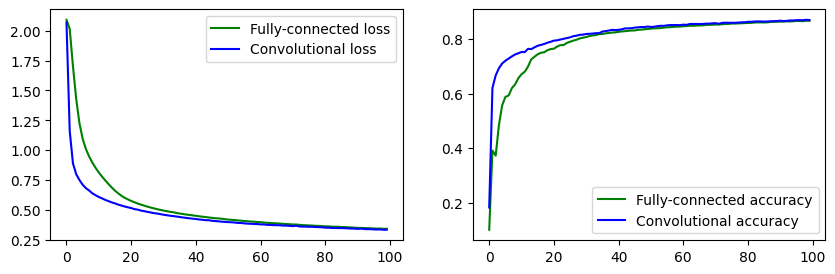

In [12]:
from matplotlib import pyplot
pyplot.figure(figsize=(10,3))
ax = pyplot.subplot(121)
# plot loss values of FC and CV network over epochs
ax.plot(fc_loss, "g-", label="Fully-connected loss")
ax.plot(cv_loss, "b-", label="Convolutional loss")
ax.legend()

ax = pyplot.subplot(122)
# plot accuracy values of FC and CV network over epochs
ax.plot(fc_acc, "g-", label="Fully-connected accuracy")
ax.plot(cv_acc, "b-", label="Convolutional accuracy")
ax.legend()

### Task 11: Learnable Parameters

Estimate roughly how many learnable parameters the two networks have by analytically computing and adding the number of parameters in each layer.

**Fully-connected Network**

For every fully-connected layer the weights $(I \cdot O)$ and the biases $(O)$ are added together, where $I$ stands for the number of input and $O$ for the number of output features.
- first fully-connected layer: $D \cdot K_1 + K_1 = 28^2 \cdot 128 + 128 = 100'480$
- second fully-connected layer: $K_1 \cdot K_2 + K_2 = 128 \cdot 64 + 64 = 8'256$
- third fully-connected layer: $K_2 \cdot O + O = 64 \cdot 10 + 10 = 650$
- total: $100'480 + 8'256 + 650 = 109'386$

**Convolutional Network**

For every convolutional layer the weights $(C \cdot O \cdot K)$ and the biases $(O)$ are added together, where $C$ stands for the number of input, $O$ for the number of output channels and $K$ for the kernel size. For the fully-conntected layer $I = K \cdot C$.
- first convolutional layer: $C \cdot Q_1 \cdot K + Q_1 = 1 \cdot 16 \cdot 7^2 + 16 = 800$
- second convolutional layer: $Q_1 \cdot Q_2 \cdot K + Q_2 = 16 \cdot 16 \cdot 5^2 + 16 = 6'416$
- fully-connected layer: $K \cdot Q_2 \cdot O + O = 5^2 \cdot 16 \cdot 10 + 10 = 4'010$
- total: $800 + 6'416 + 4'010 = 11'226$



Now, compute the number of parameters in the networks by summing the number of parameters in each layer using `pytorch` functionality.
You can use the `numel()` function from a `torch.Tensor` to provide the number of (learnable) parameters stored in a tensor.
How do you obtain this list of all learnable parameters from a `pytorch` [Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html)?

In [13]:
def parameter_count(network):
  return sum(p.numel() for p in network.parameters())

print("Fully-connected Network:", parameter_count(fc))
print("Convolutional Network:", parameter_count(cv))

Fully-connected Network: 109386
Convolutional Network: 11226
